# AuNR DA Figure 4

In [6]:
import sys
# add path for my packages
sys.path.append('C:\\Users\\katsuya2\\OneDrive - University of Illinois - Urbana\\Documents\\Python Scripts\\my_packages')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
from pathlib import Path

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

%precision 3
%matplotlib inline

# use my matplotlib style
style_p = Path("C:/Users/katsuya2/OneDrive - University of Illinois - Urbana/Documents/Python Scripts/my_packages")
plt.style.use(Path(style_p, 'my_rc_setting.mplstyle'))

In [7]:
def calc_dif(idx, ito_data, glass_data):
    Eres_glass = glass_data['eres'][idx]
    AR_glass = glass_data['ratio'][idx]

    upper_min = ito_data[ito_data['ratio'] > AR_glass]['ratio'].min()
    lower_max = ito_data[ito_data['ratio'] < AR_glass]['ratio'].max()

    if abs(upper_min - AR_glass) > abs(lower_max - AR_glass):
        AR_ito_closest = lower_max
    else:
        AR_ito_closest = upper_min

    Eres_ito = ito_data[ito_data['ratio'] == AR_ito_closest]['eres']
    dEres_IG = Eres_ito - Eres_glass
    return dEres_IG


def calculate_mean(lst):
    return sum(lst) / len(lst)


def numerical_method(ito_data, glass_data, target_nsub):
    ito_nsub = 1.96
    glass_nsub = 1.52
    dnsub_IG = ito_nsub - glass_nsub
    dEres_IG_list = []
    for idx in range(glass_data.shape[0]):
        dEres_IG = calc_dif(idx, ito_data, glass_data)
        if dEres_IG.shape == (1,): 
            dEres_IG_list.append(dEres_IG.values)

    dEres_IG_mean = calculate_mean(dEres_IG_list)
    C = dEres_IG_mean / dnsub_IG
    target_Eres = C*(target_nsub - glass_nsub) + glass_data['eres']
    return target_Eres

## input data

In [8]:
p = Path("C:/Users/katsuya2/OneDrive - University of Illinois - Urbana/Documents/Python Scripts/input_data/SPP2023")

glass_data = pd.read_csv(Path(p, '090723_glass_training.csv'))
glass_data = glass_data.drop(['corrcoef'], axis=1)
original_data = pd.read_csv(Path(p, 'New_SPP.csv'))
combined_data = pd.concat([glass_data, original_data], axis=0)
combined_data['volume'] = np.pi*(combined_data['width']**2)*combined_data['length']/4 - np.pi*(combined_data['width']**3)/12
combined_data['ratio'] = combined_data['length'] / combined_data['width']

combined_data = combined_data[(combined_data['width'] < 60) & (combined_data['length'] < 130)]
combined_data = combined_data.reset_index(drop=True)
print(combined_data.shape)

# all ITO data
ito_data = pd.read_csv(Path(p, '111623_ito_training.csv'))
ito_data['ratio'] = ito_data['length'] / ito_data['width']
ito_data = ito_data.drop(['corrcoef'], axis=1)

(1701, 7)


In [9]:
p = Path('C:/Users/katsuya2/OneDrive - University of Illinois - Urbana/Documents/Python Scripts/projects/AuNR_DA')
exp_data1 = pd.read_csv(Path(p, '080624_Zhenyang_exp_al2o3_1.csv'))
exp_data2 = pd.read_csv(Path(p, '080624_Zhenyang_exp_al2o3_2.csv'))
# convert str into list after reading csv
exp_data1['exp_ene'] = [ast.literal_eval(df) for df in exp_data1['exp_ene']]
exp_data1['exp_dfs'] = [ast.literal_eval(df) for df in exp_data1['exp_dfs']]
exp_data1['fitting'] = [ast.literal_eval(df) for df in exp_data1['fitting']]
exp_data2['exp_ene'] = [ast.literal_eval(df) for df in exp_data2['exp_ene']]
exp_data2['exp_dfs'] = [ast.literal_eval(df) for df in exp_data2['exp_dfs']]
exp_data2['fitting'] = [ast.literal_eval(df) for df in exp_data2['fitting']]
print(exp_data1.shape, exp_data2.shape)

exp_data = pd.concat([exp_data1, exp_data2], axis=0, ignore_index=True)
print(exp_data.shape)

(11, 11) (14, 11)
(25, 11)


In [10]:
X_al2o3 = exp_data.drop(['exp_ene', 'exp_dfs', 'fitting', 'imax', 'width', 'length', 'aspect_ratio', 'volume', 'surface_area'], axis=1)
yw_al2o3 = exp_data['width']
yl_al2o3 = exp_data['length']
print(X_al2o3.shape)

(25, 2)


In [11]:
X_glass = combined_data.drop(['width', 'length', 'imax', 'ratio', 'volume'], axis=1)
yw_glass = combined_data['width']
yl_glass = combined_data['length']
print(X_glass.shape)

(1701, 2)


In [12]:
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 5, 10]
}

# param_grid = {
#     'max_depth': [5, 10, 15, 20, 25, 30],
#     'min_samples_split': [2, 5, 10, 20, 50],
#     'min_samples_leaf': [1, 2, 5, 10, 20],
# }

## Glass to Al2O3

In [13]:
# Initialize GridSearchCV class
gsw = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsw.fit(X_glass, yw_glass)
yw_pred1 = gsw.predict(X_al2o3)
maew1 = mean_absolute_error(yw_al2o3, yw_pred1)

# Initialize GridSearchCV class
gsl = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsl.fit(X_glass, yl_glass)
yl_pred1 = gsl.predict(X_al2o3)
mael1 = mean_absolute_error(yl_al2o3, yl_pred1)

## Corr. Glass to Al2O3 

In [14]:
Al2O3_nsub = 1.762
Al2O3_Eres = numerical_method(ito_data, combined_data, target_nsub=Al2O3_nsub)
X_glass['eres'] = Al2O3_Eres

In [15]:
# Initialize GridSearchCV class
gsw = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsw.fit(X_glass, yw_glass)
yw_pred2 = gsw.predict(X_al2o3)
maew2 = mean_absolute_error(yw_al2o3, yw_pred2)

# Initialize GridSearchCV class
gsl = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsl.fit(X_glass, yl_glass)
yl_pred2 = gsl.predict(X_al2o3)
mael2 = mean_absolute_error(yl_al2o3, yl_pred2)

## final plot

Text(-0.18, 1, 'C')

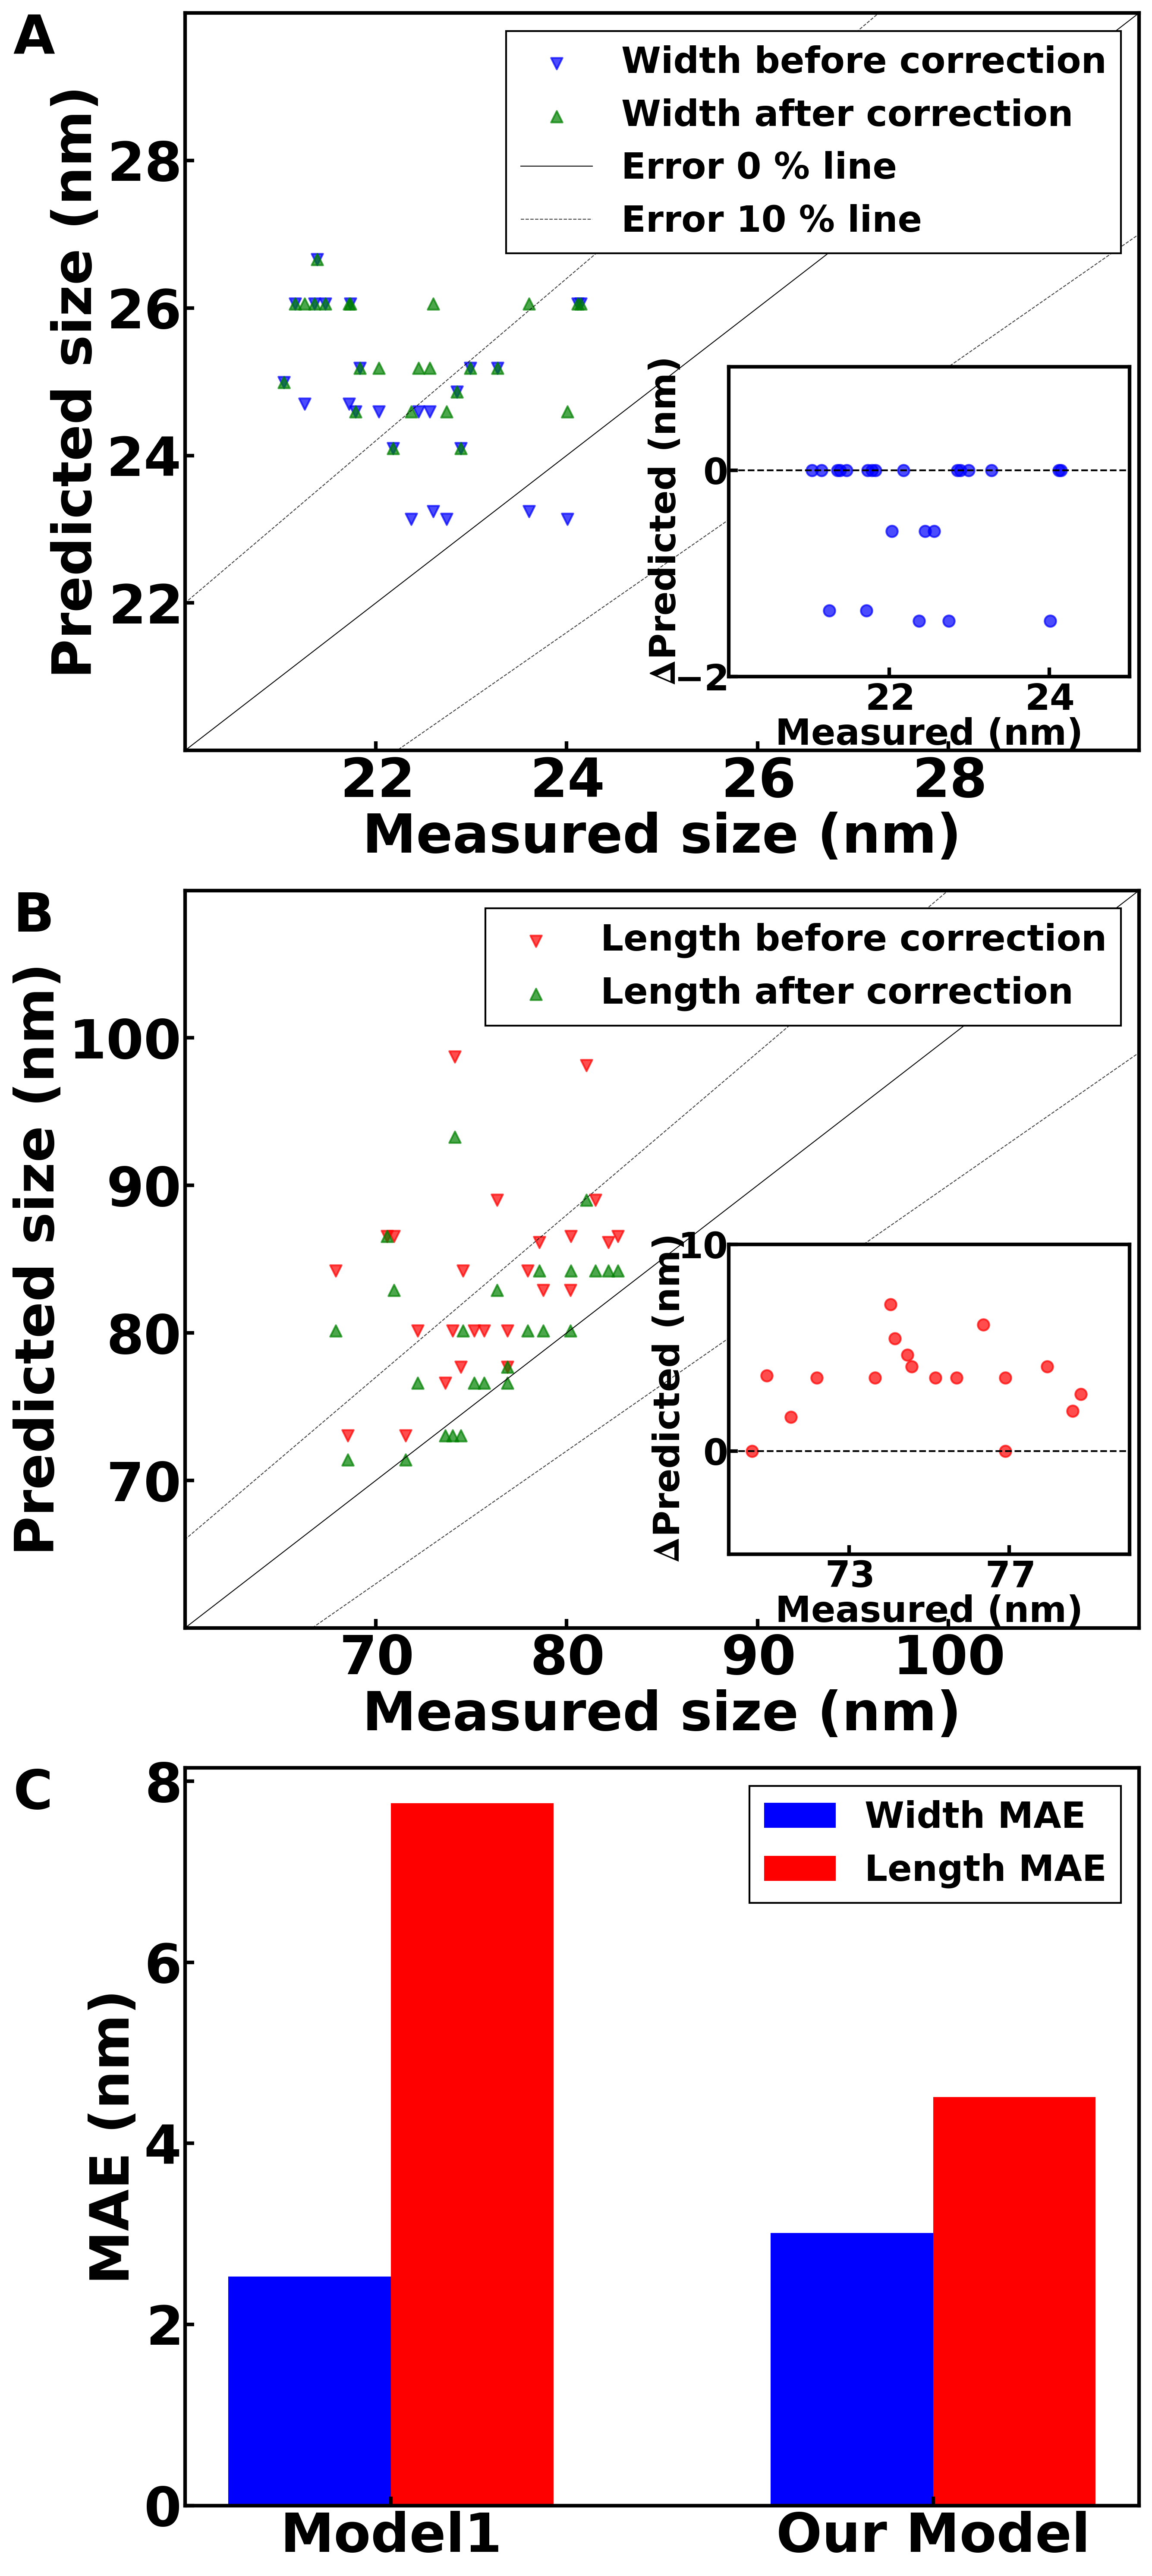

In [32]:
# Create the figure and a set of subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 20), dpi=300)

# First subplot
ax1.scatter(yw_al2o3, yw_pred1, s=40, c='b', marker='v', alpha=.7, label=f'Width before correction')
ax1.scatter(yw_al2o3, yw_pred2, s=40, c='g', marker='^', alpha=.7, label=f'Width after correction')

x = np.arange(-1, 181)
ax1.plot(x, x, c='k', lw=0.5, label='Error 0 % line')
ax1.plot(x, 1.1*x, c='k', linestyle='--', lw=0.5, label='Error 10 % line', alpha=0.75)
ax1.plot(x, 0.9*x, c='k', linestyle='--', lw=0.5, alpha=0.75)

ax1.set_xticks([22, 24, 26, 28])
ax1.set_yticks([22, 24, 26, 28])
ax1.tick_params(axis='both', labelsize=30, pad=3)
ax1.set_xlabel('Measured size (nm)', fontsize=30)
ax1.set_ylabel('Predicted size (nm)', fontsize=30)
ax1.set_xlim(20, 30)
ax1.set_ylim(20, 30)
ax1.legend(loc='upper right', fontsize=20)
ax1.text(-0.18, 1, 'A', ha='left', va='top', transform=ax1.transAxes, fontsize=30)

# add_axes([left, bottom, width, height]) values are fractions of fig width and height
# ax1ins = ax1.inset_axes([0.05, 0.62, 0.36, 0.36])
ax1ins = ax1.inset_axes([0.57, 0.1, 0.42, 0.42])

# Plot on inset
ax1ins.scatter(yw_al2o3, yw_pred1-yw_pred2, s=40, c='b', alpha=.7, label=f'MAE: {round(maew1, 2)} nm')
ax1ins.axhline(y=0, lw=1, ls="--", c='k')
ax1ins.set_xlabel('Measured (nm)', fontsize=20, labelpad=0)
ax1ins.set_ylabel('$\Delta$Predicted (nm)', fontsize=20, labelpad=-5)
ax1ins.set_xticks([22, 24])
ax1ins.set_yticks([-2, 0])
ax1ins.tick_params(axis='x', labelsize=20, pad=3)
ax1ins.tick_params(axis='y', labelsize=20, pad=1) 
ax1ins.set_xlim(20, 25)
ax1ins.set_ylim(-2, 1)

# Second subplot
ax2.scatter(yl_al2o3, yl_pred1, s=40, c='r', marker='v', alpha=.7, label=f'Length before correction')
ax2.scatter(yl_al2o3, yl_pred2, s=40, c='g', marker='^', alpha=.7, label=f'Length after correction')

ax2.plot(x, x, c='k', lw=0.5)
ax2.plot(x, 1.1*x, c='k', linestyle='--', lw=0.5, alpha=0.75)
ax2.plot(x, 0.9*x, c='k', linestyle='--', lw=0.5, alpha=0.75)

ax2.set_xticks([70, 80, 90, 100])
ax2.set_yticks([70, 80, 90, 100])
ax2.tick_params(axis='both', labelsize=30, pad=3)
ax2.set_xlabel('Measured size (nm)', fontsize=30)
ax2.set_ylabel('Predicted size (nm)', fontsize=30)
ax2.set_xlim(60, 110)
ax2.set_ylim(60, 110)
ax2.legend(loc='upper right', fontsize=20)
ax2.text(-0.18, 1, 'B', ha='left', va='top', transform=ax2.transAxes, fontsize=30)

# add_axes([left, bottom, width, height]) values are fractions of fig width and height
# ax2ins = ax2.inset_axes([0.05, 0.62, 0.36, 0.36])
ax2ins = ax2.inset_axes([0.57, 0.1, 0.42, 0.42])

# Plot on inset
ax2ins.scatter(yl_al2o3, yl_pred1-yl_pred2, s=40, c='r', alpha=.7, label=f'MAE: {round(mael1, 2)} nm')
ax2ins.axhline(y=0, lw=1, ls="--", c='k')
ax2ins.set_xlabel('Measured (nm)', fontsize=20, labelpad=0)
ax2ins.set_ylabel('$\Delta$Predicted (nm)', fontsize=20, labelpad=-5)
ax2ins.set_xticks([73, 77])
ax2ins.set_yticks([0, 10])
ax2ins.tick_params(axis='x', labelsize=20, pad=3)
ax2ins.tick_params(axis='y', labelsize=20, pad=1) 
ax2ins.set_xlim(70, 80)
ax2ins.set_ylim(-5, 10)

# Third subplot
Width_MAE = (maew1, maew2)
Length_MAE = (mael1, mael2)

n_groups = 2
index = np.arange(n_groups)
bar_width = 0.3
opacity = 1.0

ax3.bar(index - bar_width / 2, Width_MAE, bar_width, alpha=opacity, color='b', label='Width MAE', align='center') 
ax3.bar(index + bar_width / 2, Length_MAE, bar_width, alpha=opacity, color='r', label='Length MAE', align='center')

ax3.set_xticks(index, ('Model1', 'Our Model'), fontsize=30)
ax3.tick_params(axis='both', labelsize=30, pad=3)
ax3.set_ylabel('MAE (nm)', fontsize=30)
ax3.legend(fontsize=20)
ax3.text(-0.18, 1, 'C', ha='left', va='top', transform=ax3.transAxes, fontsize=30)